In [2]:
!pip install mne

In [7]:
import os
import numpy as np
import mne
from mne.externals.pymatreader import read_mat
import scipy.signal as sig
import matplotlib.pyplot as plt

In [17]:
raw = read_mat(
    "/home/malyshev/Projects/hackthat-p300/data/S1.mat"
)
fs = 250
raw["info"] = mne.create_info(["1","2","3","4","5","6","7","8"], 250)

In [4]:
raw = Map(raw)
trig = raw['trig']
data = raw['y']

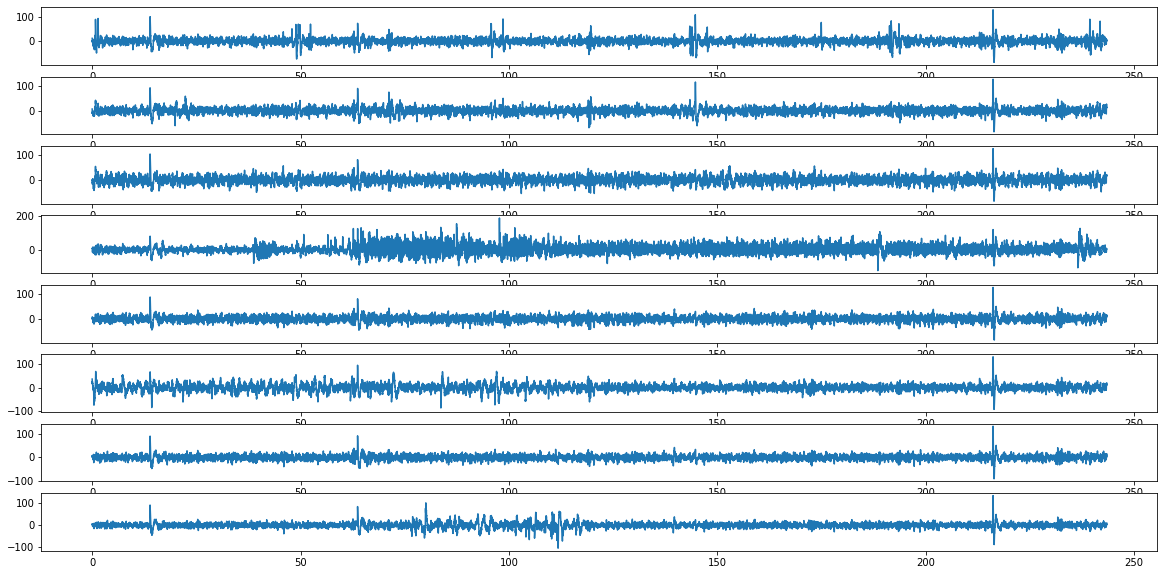

In [53]:
def plot_signal(signals: np.ndarray, sep=False):
    plt.figure(figsize=[20,10])
    N = signals.shape[0]
    for i in range(signals.shape[1]):
        if sep:
            plt.subplot(8,1,i+1)
        plt.plot(np.linspace(0,N/fs,N),signals[:,i])
    plt.show()

plot_signal(data, True)

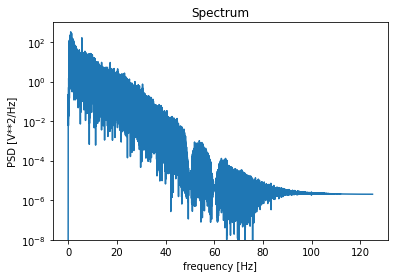

In [54]:
f, Pxx_den = sig.periodogram(data[:,0], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Spectrum')
plt.show()

## Filter and preview

In [63]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sig.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

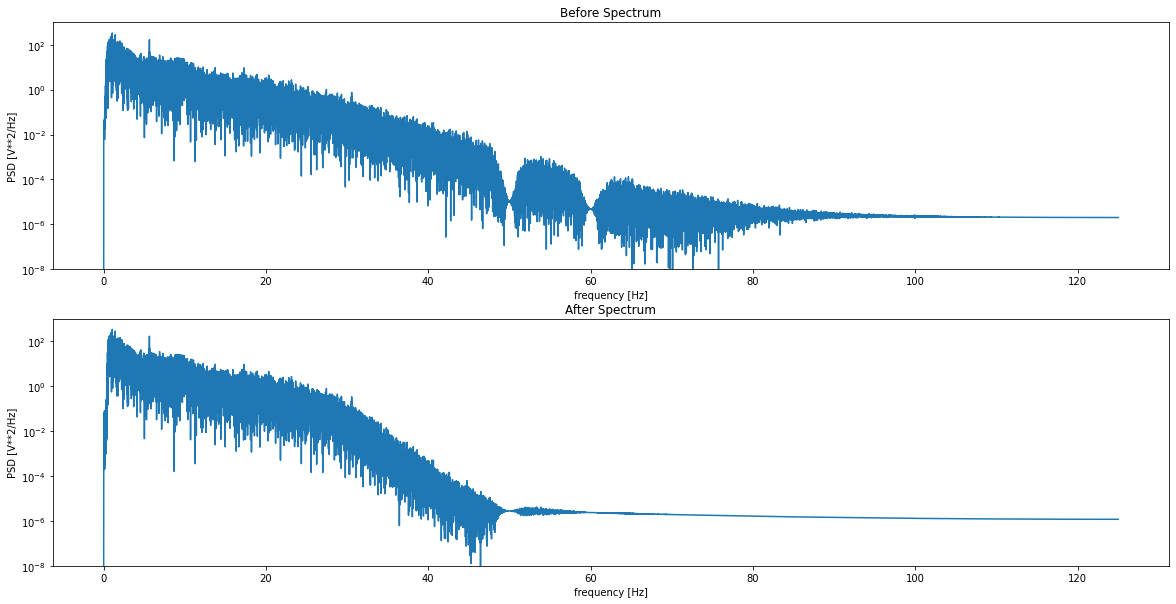

In [153]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.semilogy(*sig.periodogram(data[:,0], fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Before Spectrum')


plt.subplot(2,1,2)
plt.semilogy(*sig.periodogram(res, fs))
plt.ylim([1e-8, 1e3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('After Spectrum')
plt.show()

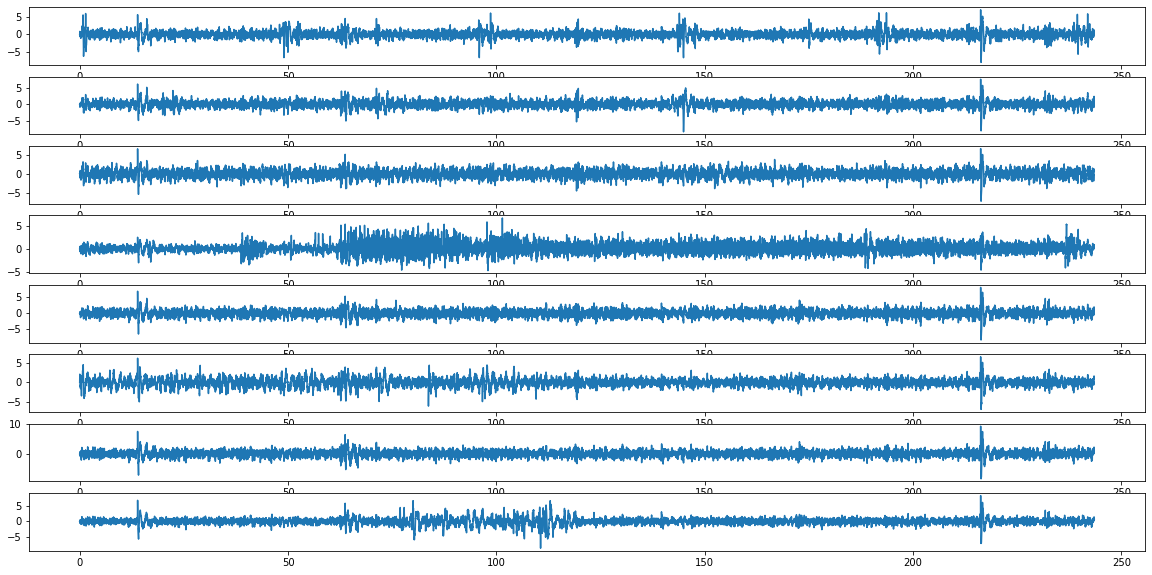

In [125]:
filtered = data.copy()
for i in range(filtered.shape[1]):
    filtered[:,i] = butter_bandpass_filter(data[:,i], 0.5, 30, fs)
filtered = (filtered - filtered.mean(0)[None]) / filtered.std(0)[None]
plot_signal(filtered, True)

## Show near label

75


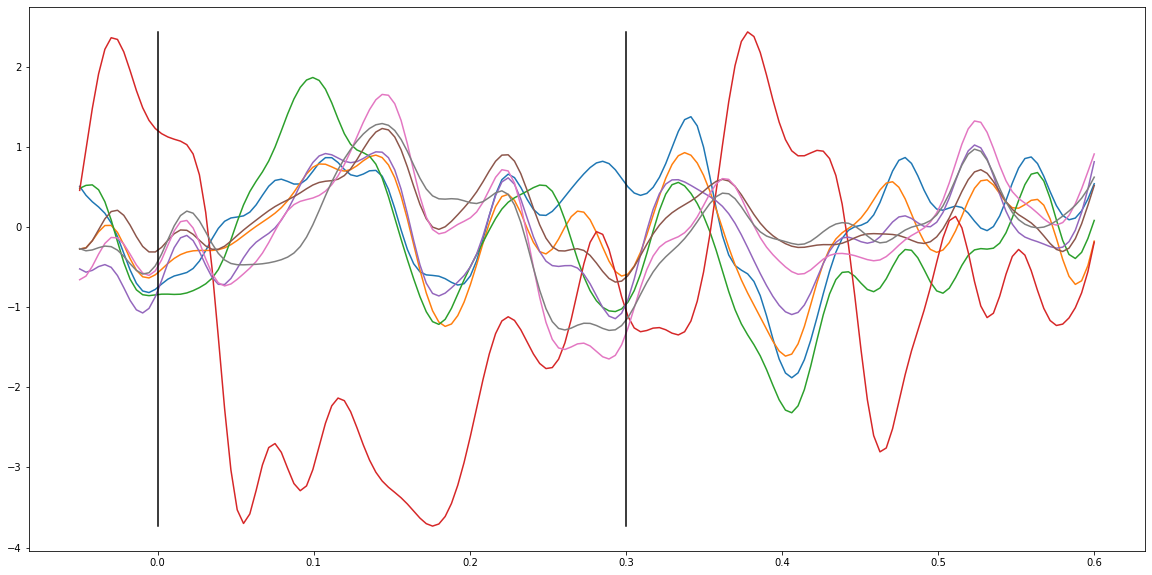

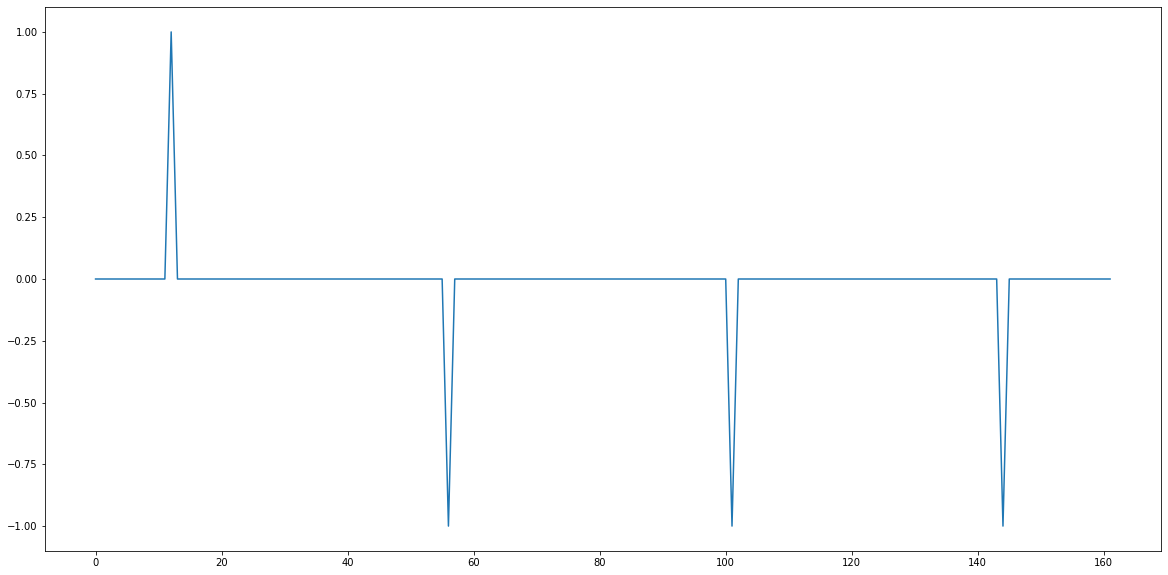

In [126]:
last = np.where(trig == 1)[0][-1]
p300 = int(0.3 * fs)
before = int(0.05 * fs)
print(p300)
plt.figure(figsize=(20,10))
sec = filtered[last-before:last + p300*2]
plt.plot(np.linspace(-0.05,0.3*2,sec.shape[0]),sec)
plt.plot([0.0]*2, [sec.min(), sec.max()], c='black')
plt.plot([0.3]*2, [sec.min(), sec.max()], c='black')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(trig[last-before:last + p300*2])
plt.show()

### Classification

In [114]:
from sklearn.discriminant_analysis import *
from sklearn.decomposition import PCA

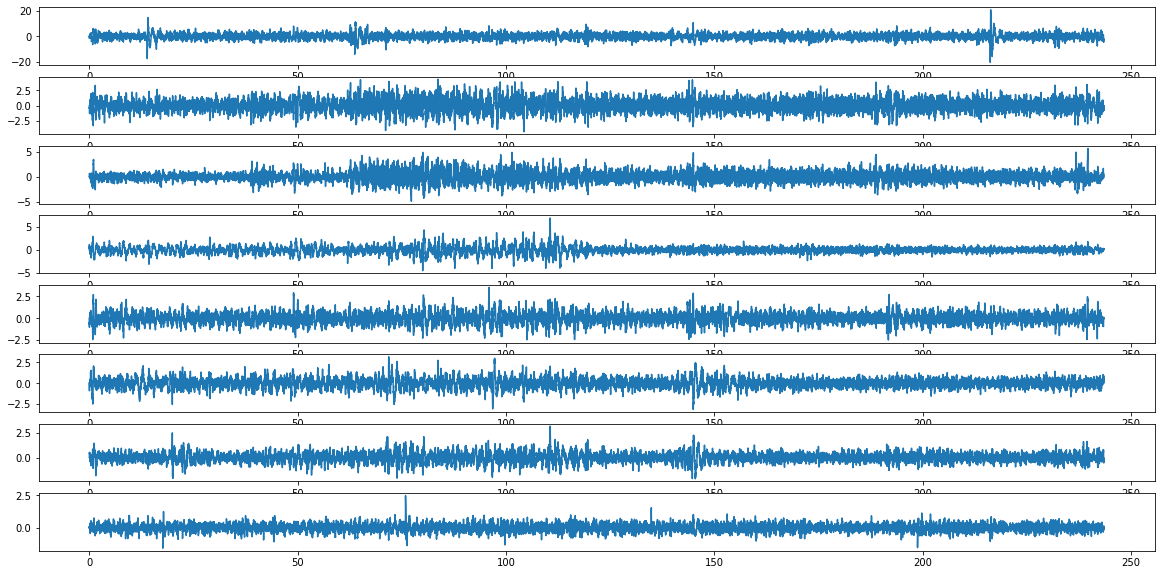

In [132]:
pca = PCA()
transformed = pca.fit_transform(filtered)
plot_signal(transformed, True)

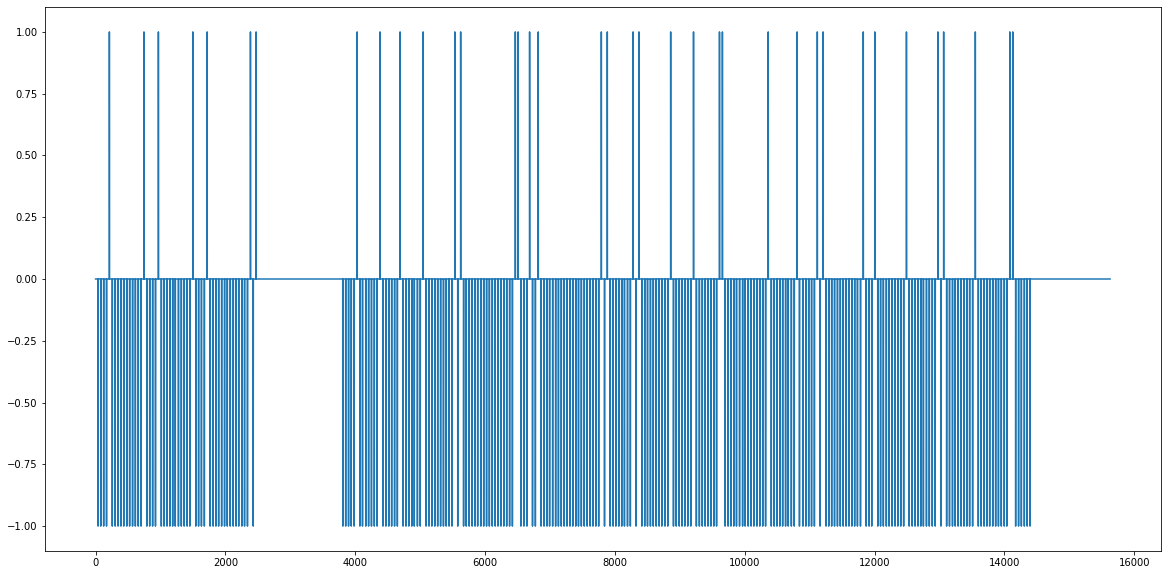

In [150]:
plt.figure(figsize=(20,10))
plt.plot(trig[last-p300*1000:last + p300*20])
plt.show()